In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
df = pd.read_csv(r'/content/DailyDelhiClimateTrain.csv',parse_dates = True,index_col='date')

In [5]:
df.head()


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [6]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


Text(0, 0.5, 'Units of measurement')

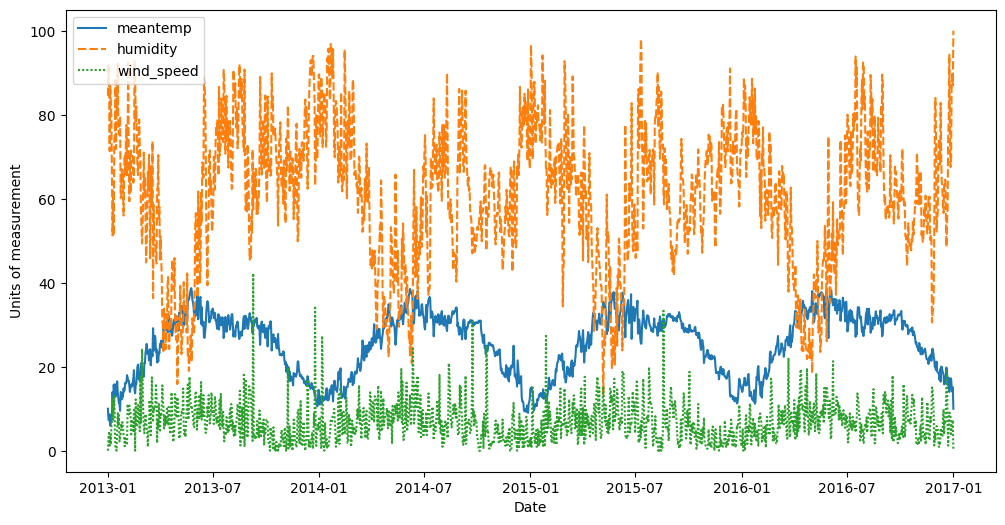

In [7]:
sns.lineplot(df.drop('meanpressure',axis=1))
plt.xlabel('Date')
plt.ylabel('Units of measurement')

Text(0.5, 1.0, 'Average pressure')

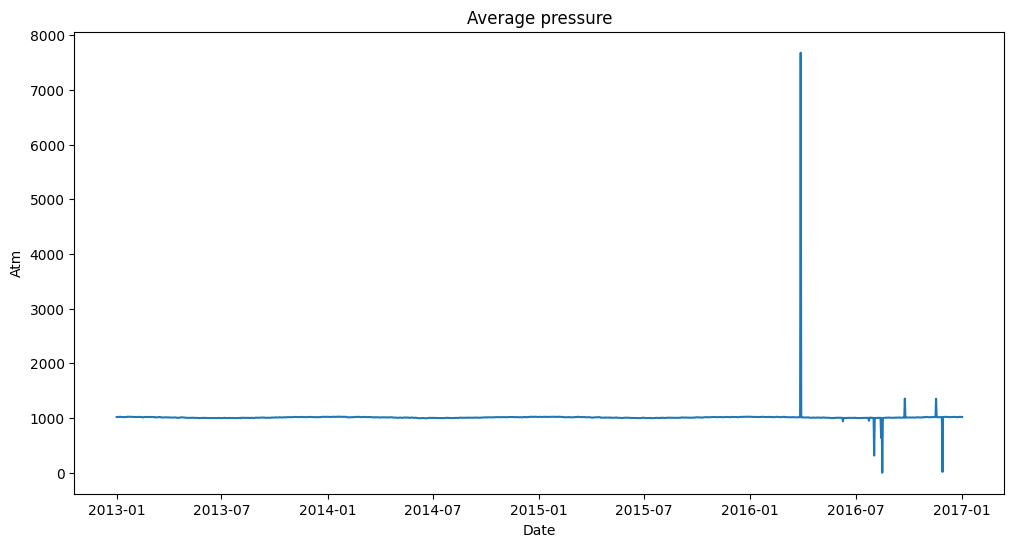

In [8]:
sns.lineplot(df.meanpressure)
plt.xlabel('Date')
plt.ylabel('Atm')
plt.title('Average pressure')

<Axes: >

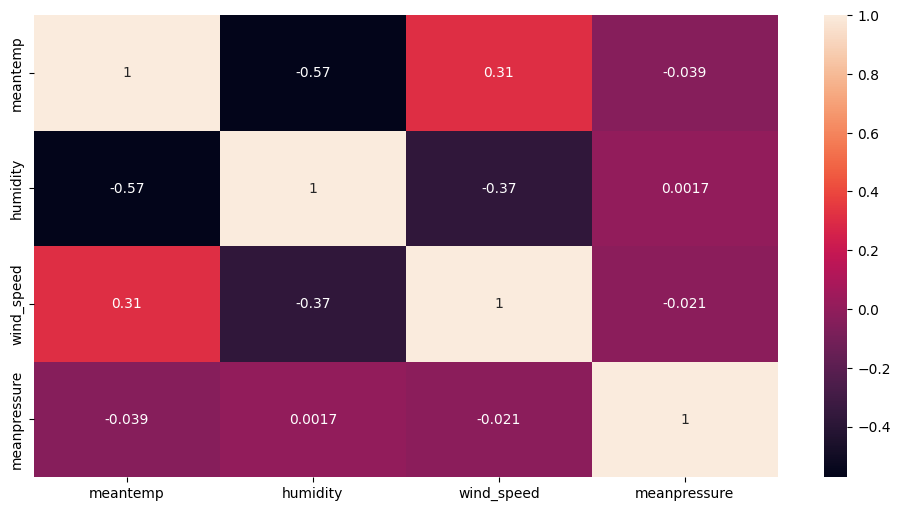

In [9]:
sns.heatmap(df.corr(),annot=True)

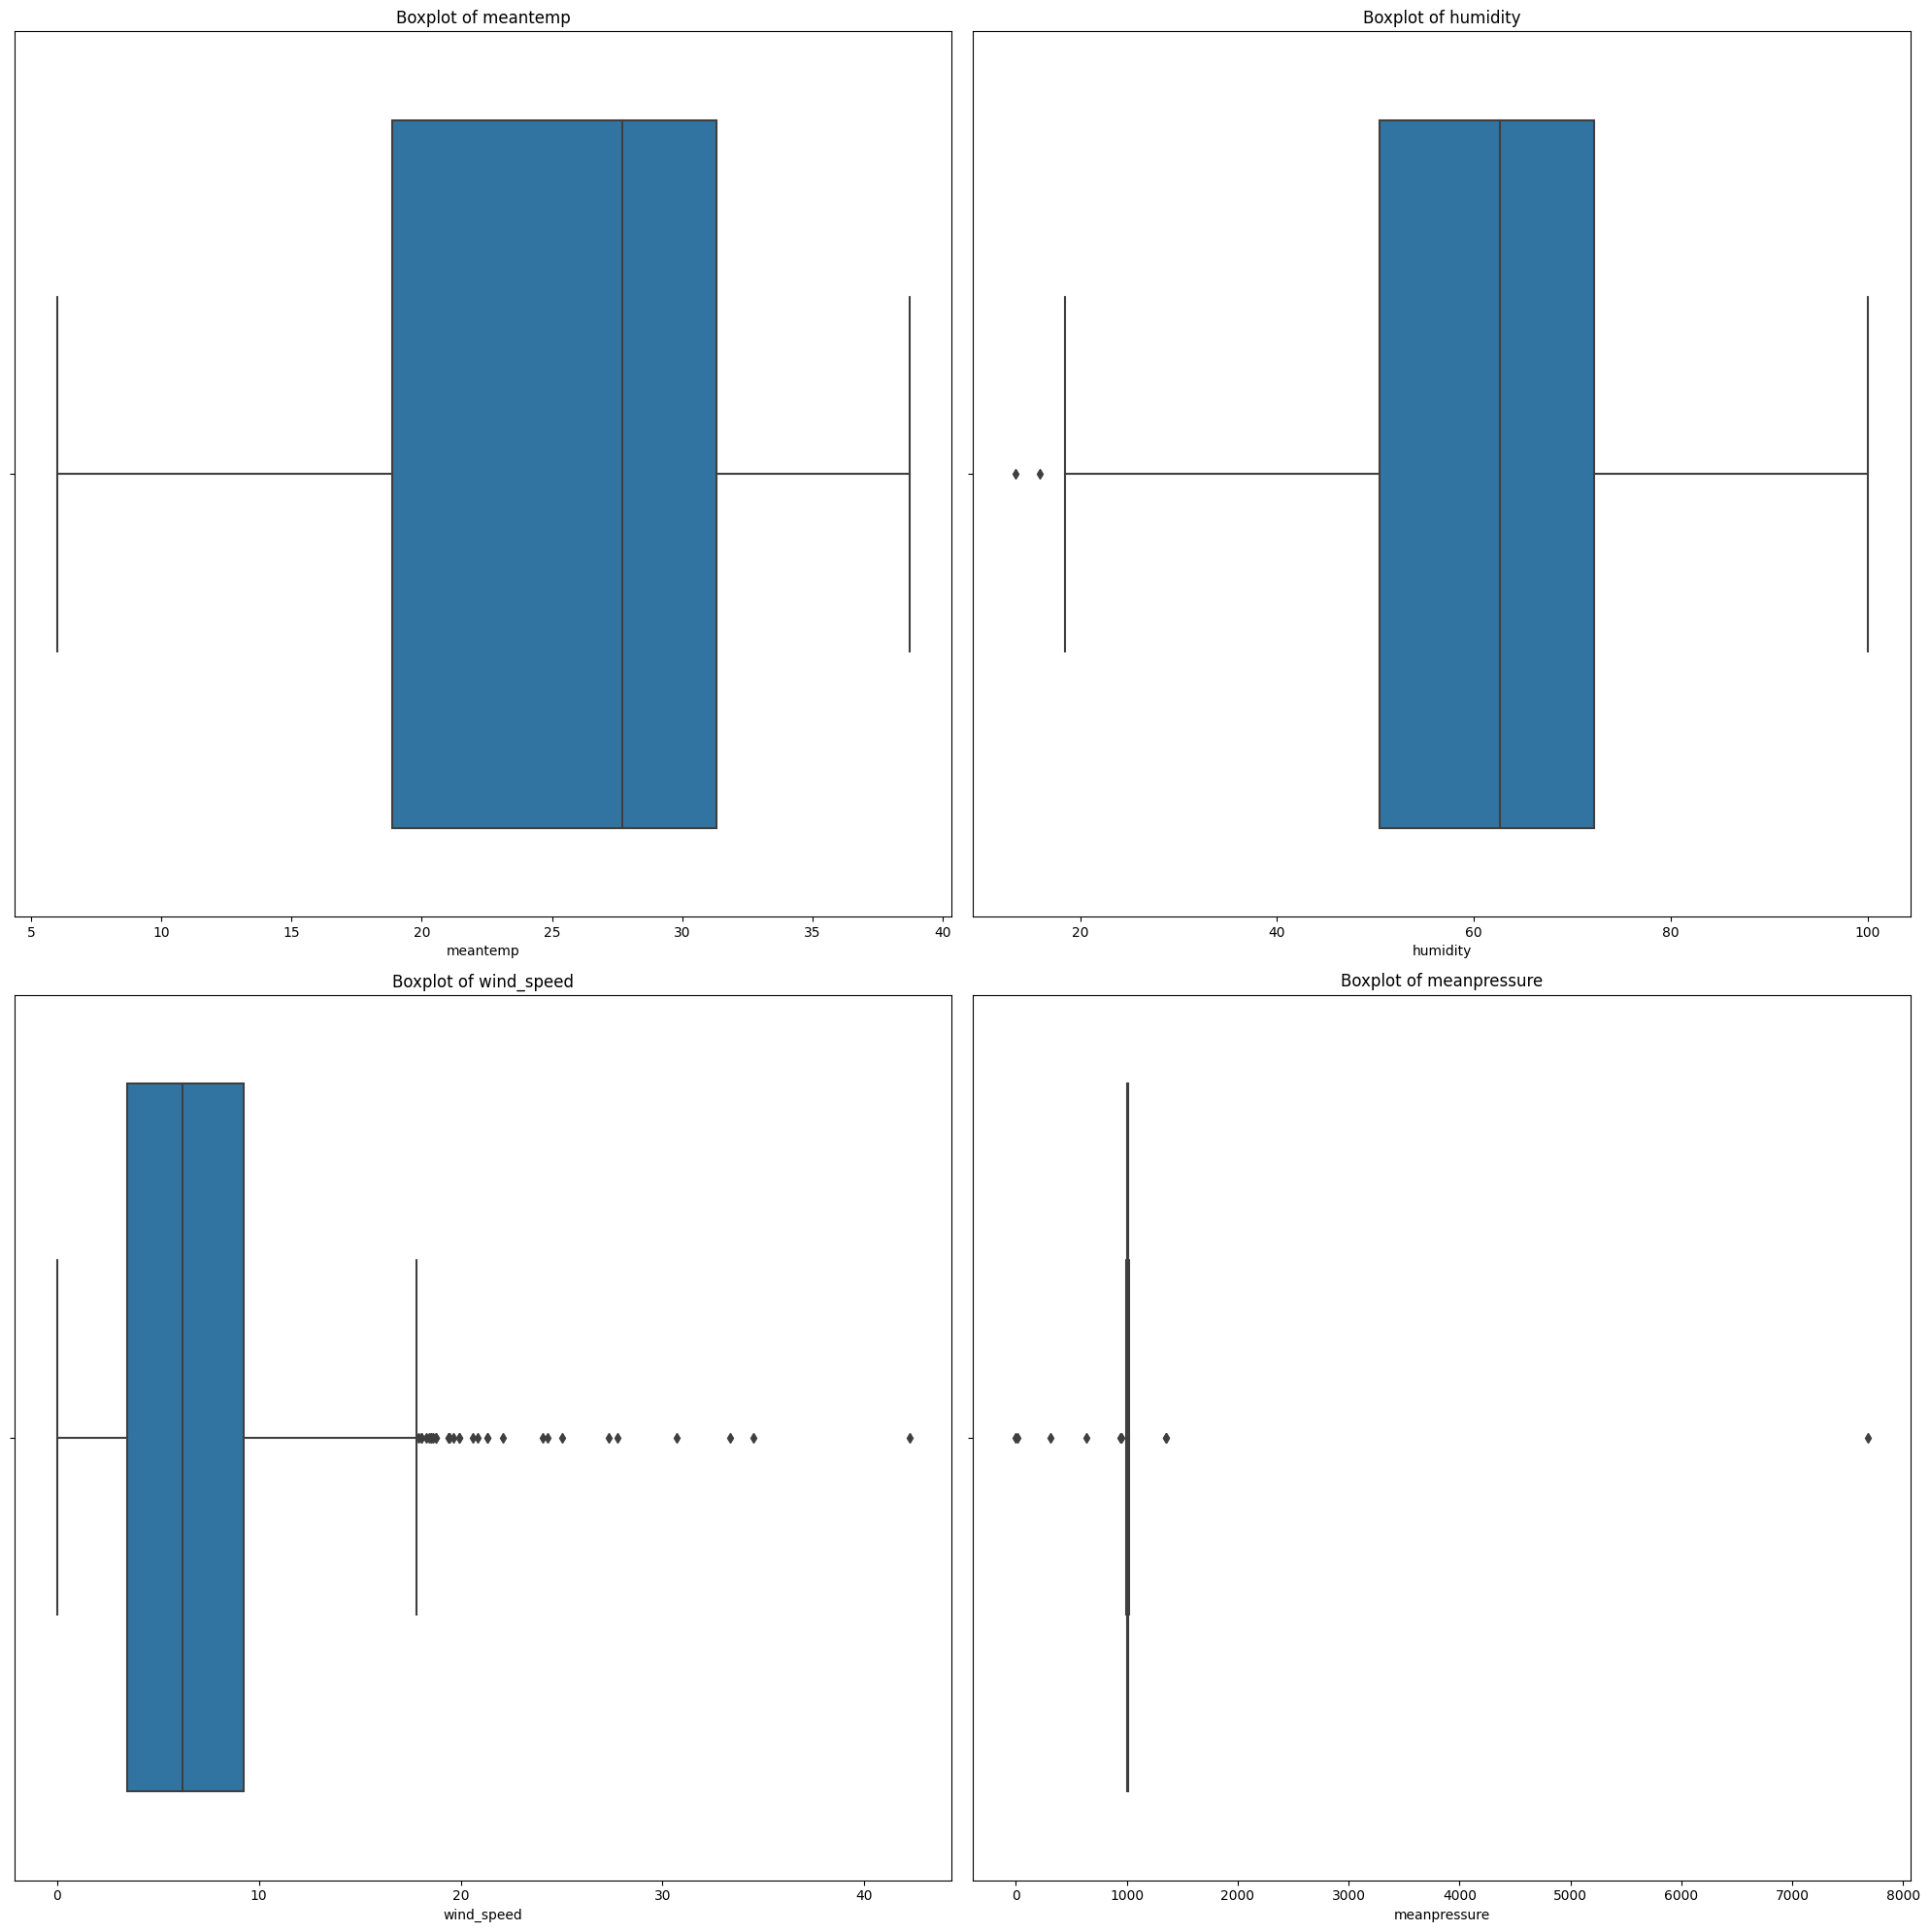

In [10]:
def plot_boxplots(dataframe):
    num_columns = dataframe.select_dtypes(include=['number']).columns
    num_plots = len(num_columns)
    rows = (num_plots + 1) // 2

    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(20, 20))

    for i, column in enumerate(num_columns):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        sns.boxplot(x=dataframe[column], ax=ax)
        ax.set_title(f"Boxplot of {column}")
        ax.set_xlabel(column)

    plt.tight_layout()
    plt.show()

plot_boxplots(df)

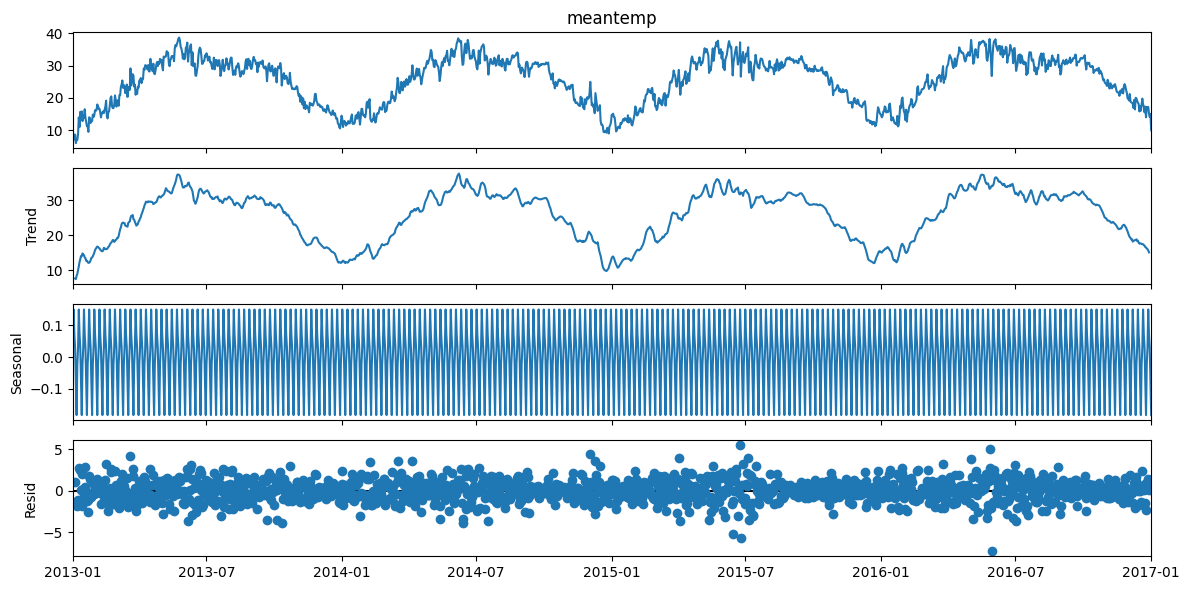

In [11]:
decompose=seasonal_decompose(df.meantemp,model='additive')
decompose.plot()
plt.show()

In [12]:
import pandas as pd

def replace_outliers_with_quantiles(df, columns, lower_quantile=0.01, upper_quantile=0.99):
    """

    - df (pd.DataFrame): DataFrame,
    - columns (list):
    - lower_quantile (float, optional): 0.01.
    - upper_quantile (float, optional):  0.99.
    """
    df_copy = df.copy()

    for column in columns:
        lower_limit = df_copy[column].quantile(lower_quantile)
        upper_limit = df_copy[column].quantile(upper_quantile)
        df_copy[column] = df_copy[column].clip(lower_limit, upper_limit)

    return df_copy

In [13]:
def remove_outliers(df, columns, k=1.5):
    """

    df (pandas.DataFrame):
    columns (list):
    k (float):
    """
    df_copy = df.copy()

    for column in columns:

        q1 = df_copy[column].quantile(0.25)
        q3 = df_copy[column].quantile(0.75)

        iqr = q3 - q1
        df_copy[column] = df_copy[column].clip(lower=q1 - k * iqr, upper=q3 + k * iqr)

    return df_copy

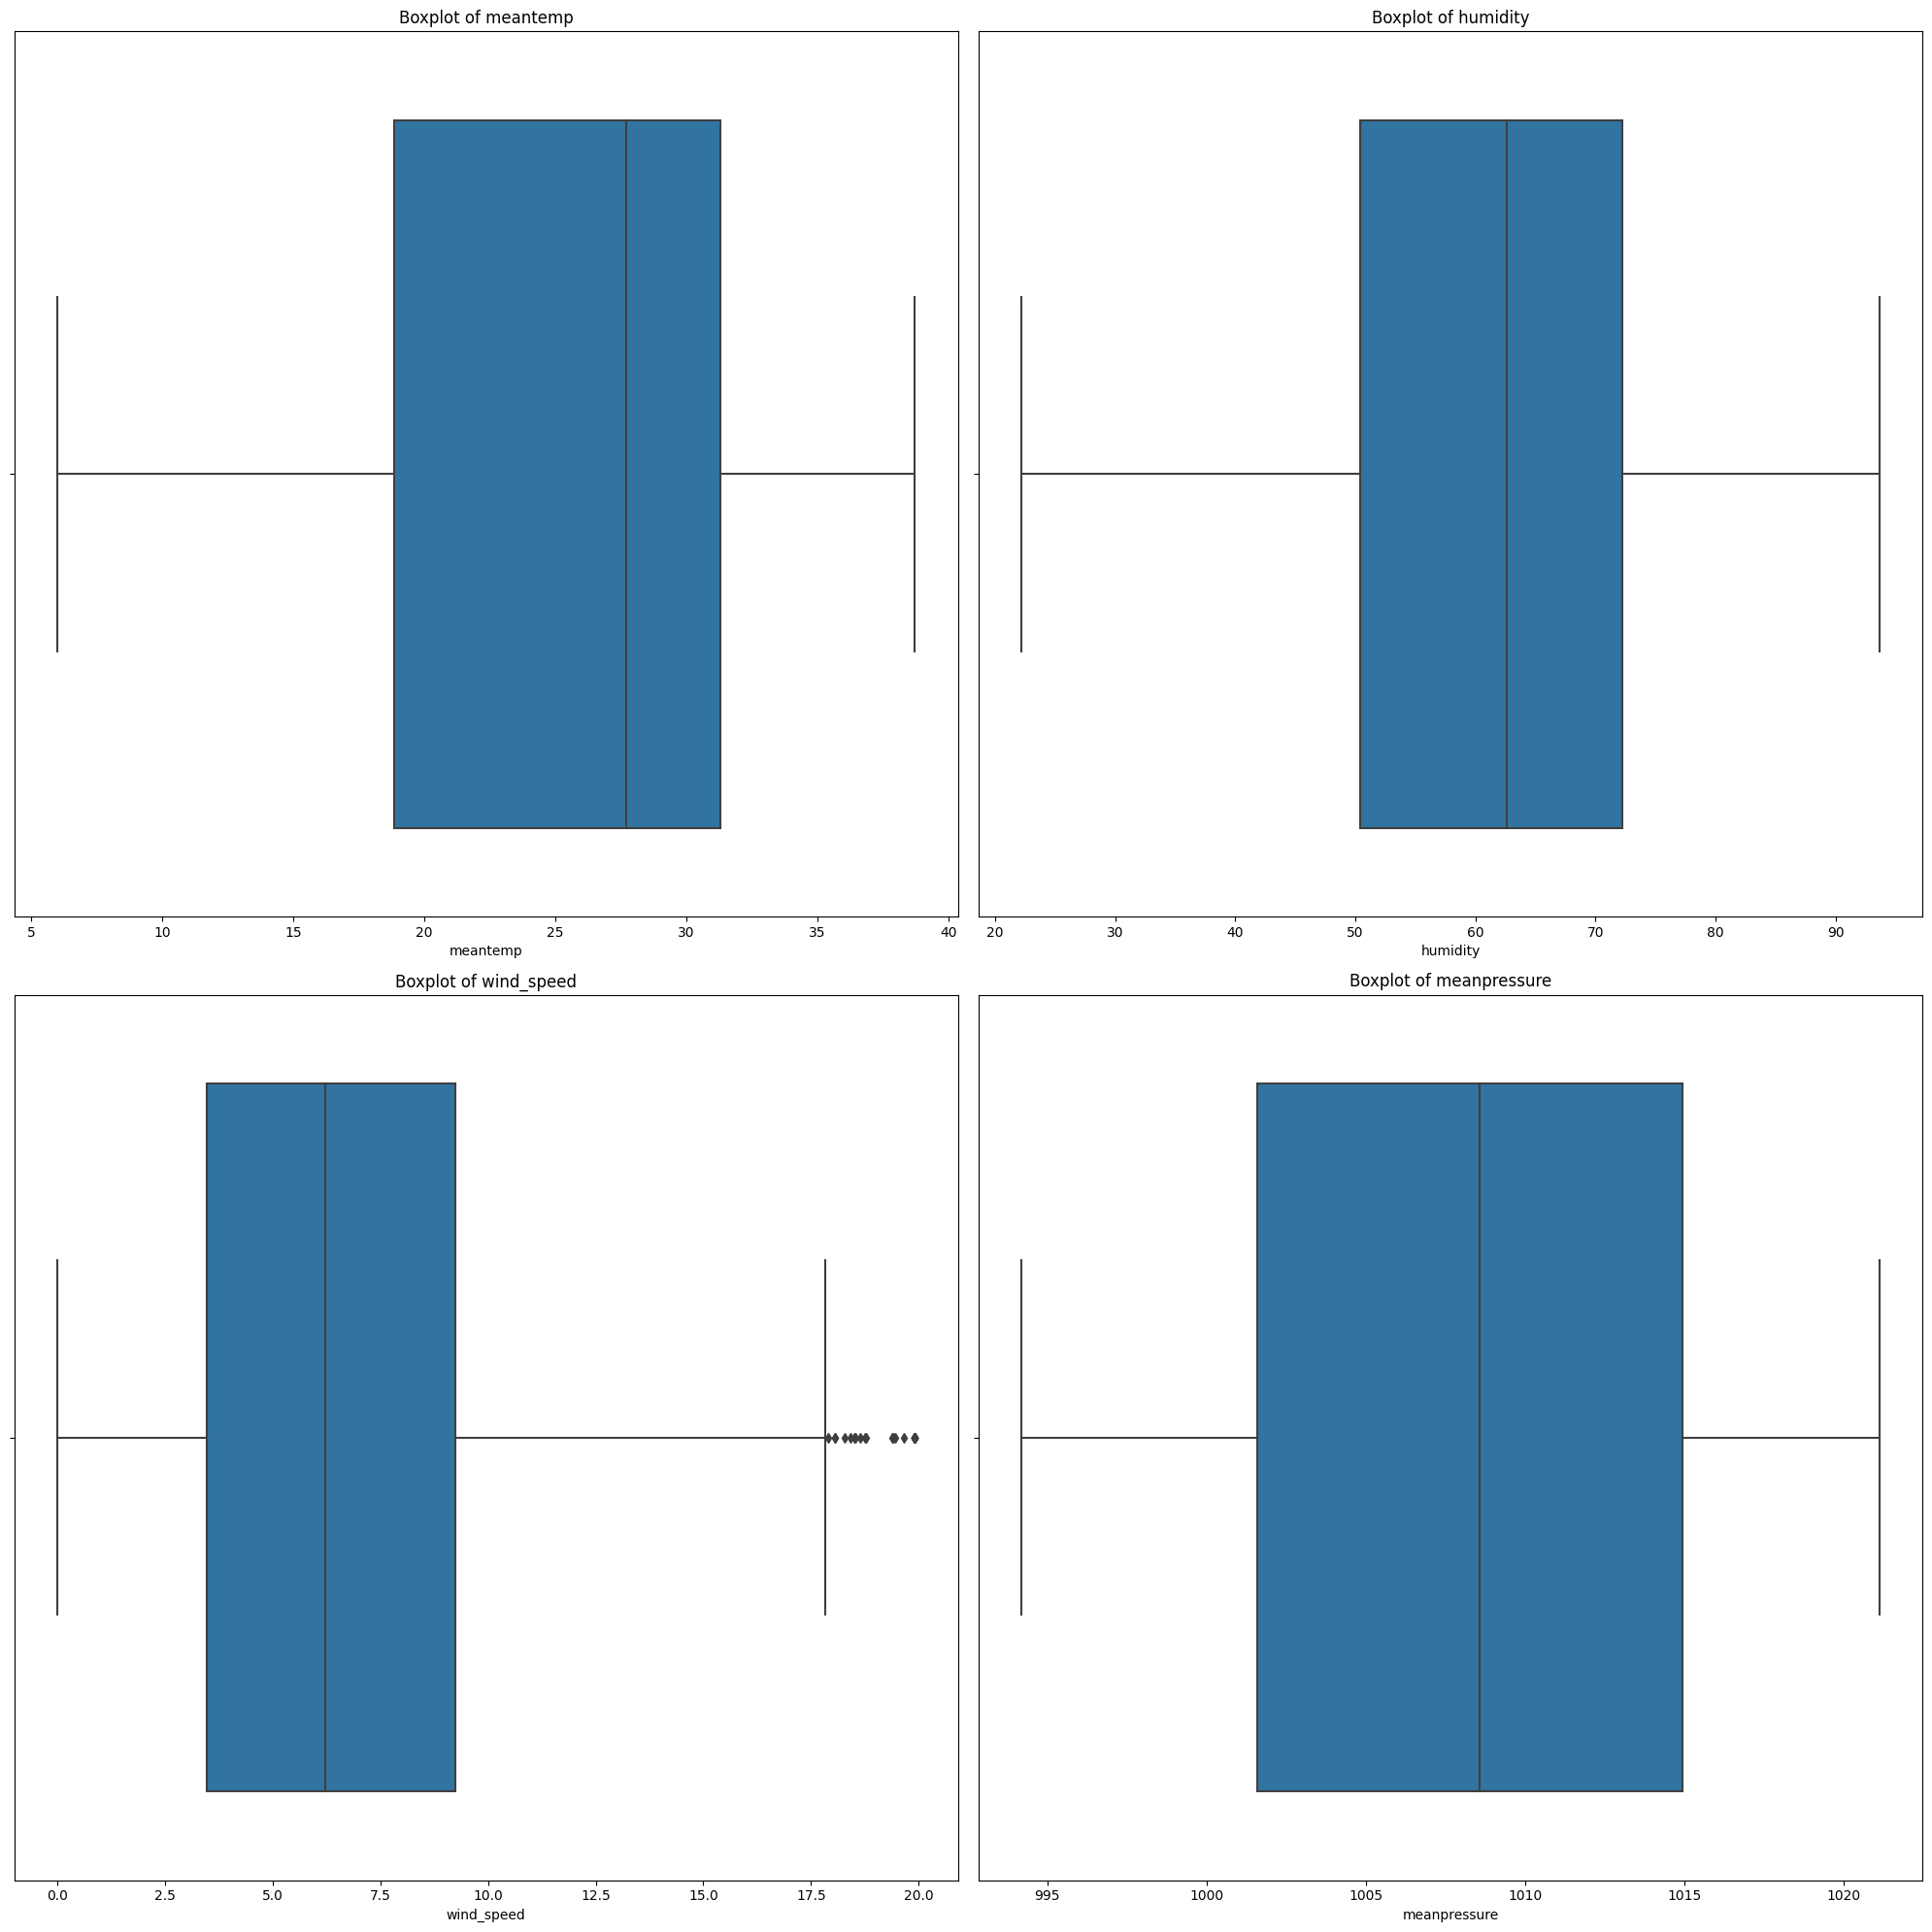

In [14]:
df_clean=replace_outliers_with_quantiles(df, ['wind_speed', 'meanpressure','humidity'])
plot_boxplots(df_clean)

<Axes: xlabel='date', ylabel='meanpressure'>

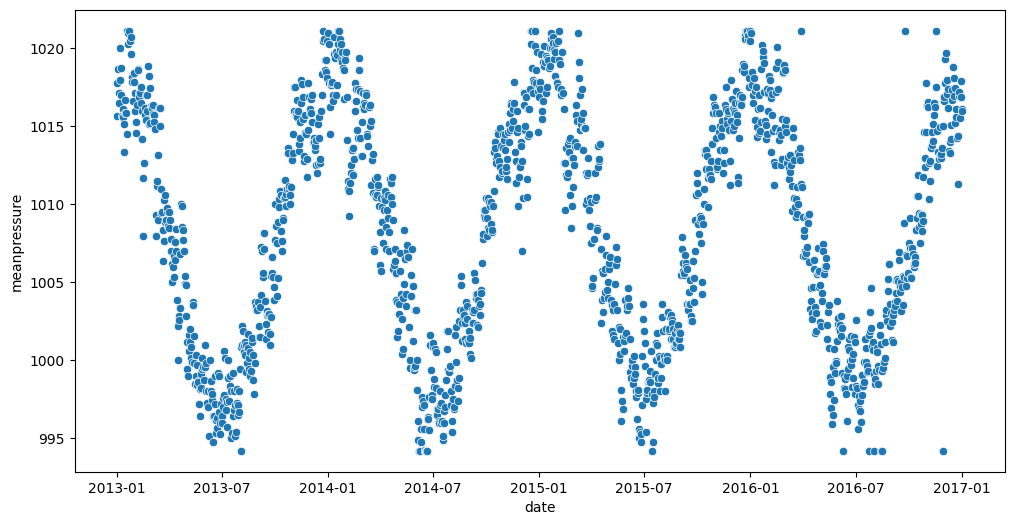

In [15]:
sns.scatterplot(df_clean.meanpressure)

Text(0.5, 1.0, 'replace_outliers_with_quantiles')

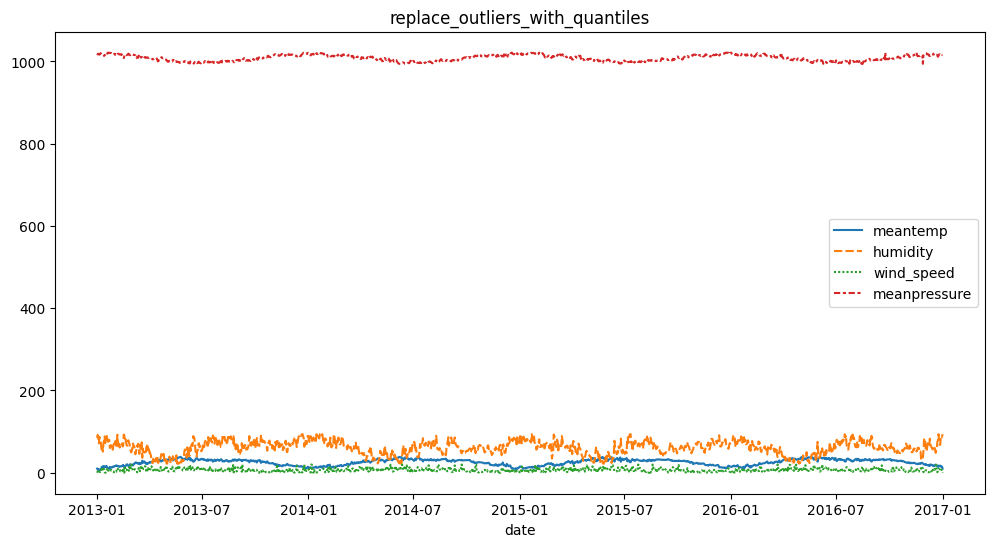

In [16]:
sns.lineplot(df_clean)
plt.title('replace_outliers_with_quantiles')

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def create_raincloud_plot(df, feature_names):

    data_x = [df[feature].values for feature in feature_names]
    palette = sns.color_palette("tab10", len(feature_names))
    violin_colors = [palette[i] for i in range(len(feature_names))]
    scatter_colors = [palette[i] for i in range(len(feature_names))]

    fig, ax = plt.subplots(figsize=(12, 6))
    vp = ax.violinplot(data_x, positions=np.arange(1, len(feature_names) + 1),
                   showmeans=False,
                    showextrema=False,
                    showmedians=False,
                    vert=False)

    for idx, b in enumerate(vp['bodies']):
        b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], idx+1, idx+2)
        b.set_color(violin_colors[idx])
        b.set_alpha(0.6)
    bp = ax.boxplot(data_x, patch_artist=True,
                    vert=False,
                    positions=np.arange(0.9, len(feature_names) + 0.9),
                    flierprops={'markersize':4})
    for box in bp['boxes']:
        box.set(fill=False)
    for idx, features in enumerate(data_x):
        y = np.full(len(features), idx + .9)
        idxs = np.arange(len(y))
        out = y.astype(float)
        out.flat[idxs] += np.random.uniform(low=-.05, high=.05, size=len(idxs))
        y = out
        plt.scatter(features, y, s=.3, color=scatter_colors[idx])

    plt.yticks(np.arange(1, len(feature_names) + 1, 1), feature_names)
    plt.xlabel('Значения')
    plt.title("Raincloud plot")
    plt.show()

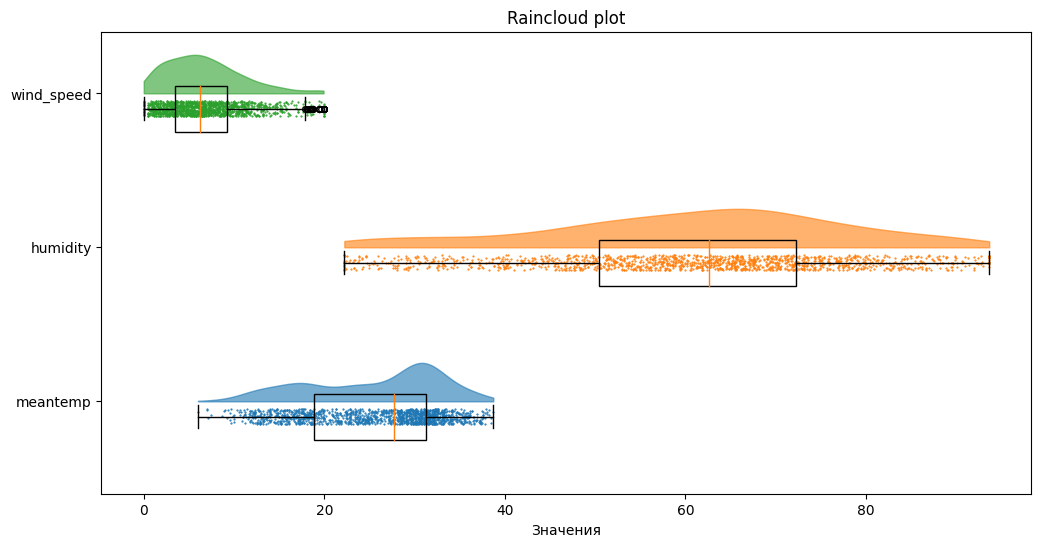

In [18]:
create_raincloud_plot(df_clean,['meantemp', 'humidity', 'wind_speed'])

In [19]:
df_clean['humidity']=df_clean['humidity'].rolling(window=30).mean()
df_clean['wind_speed']=df_clean['wind_speed'].rolling(window=30).mean()
df_clean['meanpressure']=df_clean['meanpressure'].rolling(window=30).mean()
df_clean['lag_1'] = df_clean.meantemp.shift(periods=1) # lag 1
df_clean['lag_4'] = df_clean.meantemp.shift(periods=4) # lag 4
df_clean.dropna(inplace=True)

<Axes: >

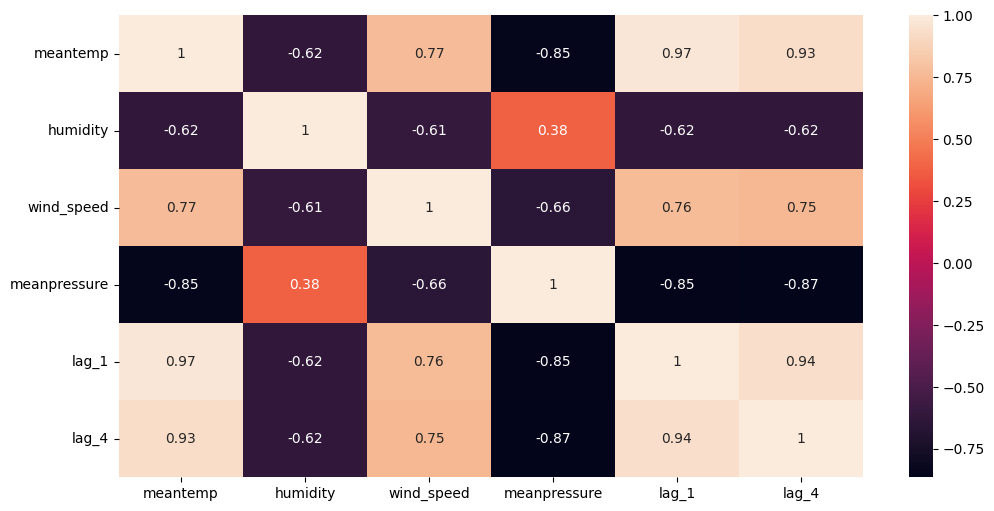

In [20]:
sns.heatmap(df_clean.corr(),annot=True)

In [21]:
train  = df_clean[:'2015-07']
test = df_clean['2015-08':]
X_tarin = train.drop(['meantemp'],axis=1)
X_test = test.drop(['meantemp'],axis=1)
y_tarin = train['meantemp']
y_test = test['meantemp']


In [22]:
import statsmodels.api as sm
X_1=sm.add_constant(X_tarin)
lr=sm.OLS(endog=y_tarin,exog=X_1)
result=lr.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               meantemp   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     3372.
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:54:48   Log-Likelihood:                -1750.1
No. Observations:                 913   AIC:                             3512.
Df Residuals:                     907   BIC:                             3541.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           53.3080     18.187      2.931   

In [23]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_tarin,y_tarin)

LinearRegression()

In [24]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X_tarin, y_tarin, cv=3)
print("Average R-squared: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Average R-squared: 0.94 (+/- 0.04)


In [25]:
pred=lr.predict(X_test)
predd=pd.Series(pred,index=y_test.index)

In [26]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
print('MEA:',mean_absolute_error(y_test, predd))
print('RMSE:',np.sqrt(mean_squared_error(y_test, predd)))

MEA: 1.1293766094434596
RMSE: 1.4740276122025195


Text(0.5, 1.0, 'Model predictions based on linear regression')

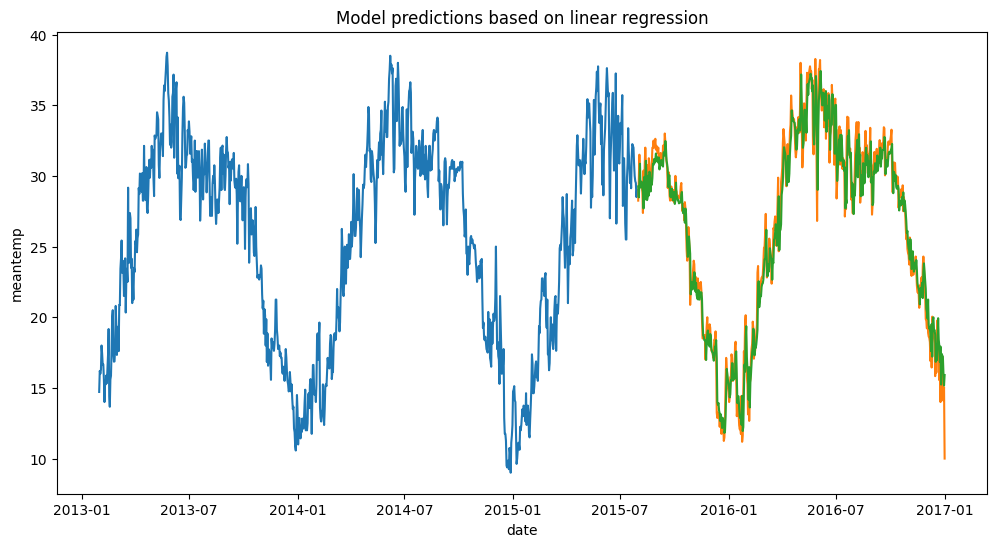

In [27]:
sns.lineplot(y_tarin)
sns.lineplot(y_test)
sns.lineplot(predd)
plt.title('Model predictions based on linear regression')

In [28]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_tarin,y_tarin)

RandomForestRegressor()

In [29]:
scores = cross_val_score(rf, X_tarin, y_tarin, cv=3)
print("Average R-squared: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Average R-squared: 0.93 (+/- 0.04)


In [30]:
rf_pred= pd.Series(rf.predict(X_test),index=y_test.index)

In [31]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
print('MEA:',mean_absolute_error(y_test, rf_pred))
print('RMSE:',np.sqrt(mean_squared_error(y_test, rf_pred)))

MEA: 1.254013338475813
RMSE: 1.6184675361224734


Text(0.5, 1.0, ' Model predictions for a random forest')

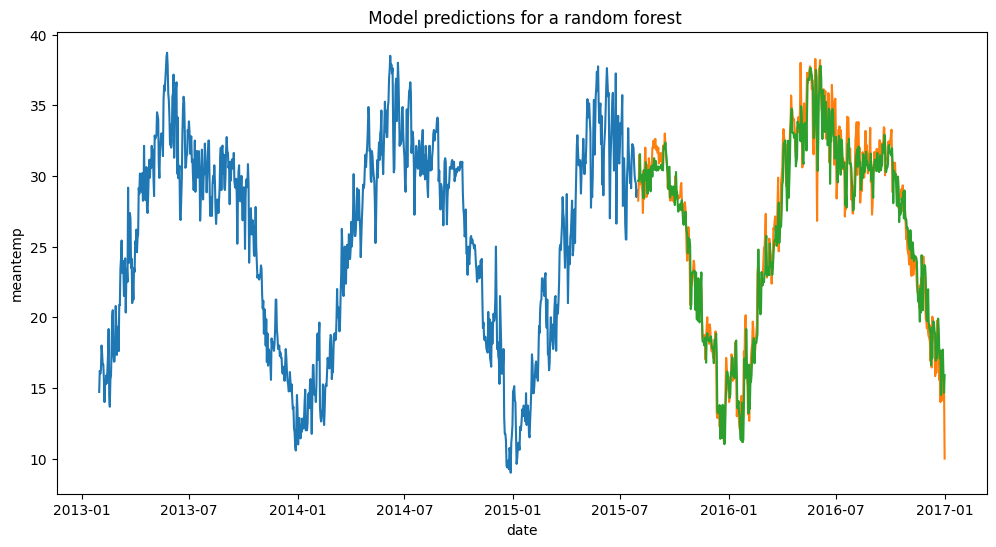

In [32]:
sns.lineplot(y_tarin)
sns.lineplot(y_test)
sns.lineplot(rf_pred)
plt.title(' Model predictions for a random forest')